In [1]:
import os
import time
import datasets
import evaluate
import torch
import pandas as pd
import numpy as np
import onnx
import onnxruntime as ort
from IPython.display import HTML, display
import matplotlib.pyplot as plt 
import torch.nn.functional as F
from transformers import Trainer
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification


In [2]:
finer = datasets.load_dataset("nlpaueb/finer-139")

## Dataset Entities Distribution

In [59]:
finer_train = finer['train']
finer_test = finer['test']
finer_validation = finer['validation']

In [65]:
entities_names = finer_train.features["ner_tags"].feature.names

In [69]:
dict_entities = {}


In [77]:
def distribution_entities(row):
    for ner_tag in row['ner_tags']:
        if ner_tag!=0:
            if ner_tag in dict_entities:
                dict_entities[ner_tag]+=1
            else:
                dict_entities[ner_tag]=1


In [78]:
finer.map(distribution_entities)
dict_sorted_finer_entities = dict(sorted(dict_entities.items(), key= lambda item: item[1], reverse=True))
dict_sorted_finer_entities

Map:   0%|          | 0/900384 [00:00<?, ? examples/s]

Map:   0%|          | 0/112494 [00:00<?, ? examples/s]

Map:   0%|          | 0/108378 [00:00<?, ? examples/s]

{0: 50755070,
 41: 55344,
 87: 44190,
 34: 43407,
 37: 39474,
 4: 30480,
 8: 27486,
 57: 26052,
 6: 22374,
 30: 20337,
 140: 17289,
 74: 16455,
 64: 16419,
 43: 15957,
 128: 15831,
 55: 14319,
 83: 13629,
 60: 13338,
 107: 12984,
 102: 12474,
 129: 12018,
 82: 11577,
 35: 11499,
 59: 11376,
 32: 11310,
 138: 11160,
 17: 11064,
 90: 10848,
 70: 10791,
 105: 10653,
 131: 10620,
 53: 10617,
 158: 10218,
 88: 9759,
 113: 9534,
 139: 9078,
 40: 8862,
 80: 8739,
 132: 8322,
 58: 7977,
 133: 7794,
 142: 7650,
 145: 7584,
 44: 7380,
 152: 7350,
 124: 7221,
 67: 7200,
 99: 7125,
 156: 7116,
 147: 7107,
 16: 7017,
 165: 6993,
 85: 6843,
 100: 6648,
 25: 6585,
 2: 6585,
 91: 6342,
 66: 6279,
 14: 6186,
 31: 6039,
 50: 5826,
 168: 5823,
 51: 5685,
 12: 5637,
 72: 5619,
 89: 5604,
 52: 5598,
 119: 5556,
 94: 5337,
 42: 5319,
 77: 5304,
 137: 5286,
 18: 5271,
 98: 5247,
 159: 5184,
 45: 5178,
 144: 5175,
 97: 4950,
 92: 4941,
 69: 4941,
 62: 4893,
 78: 4857,
 149: 4746,
 148: 4668,
 39: 4620,
 22: 4

#### Most repeated entities

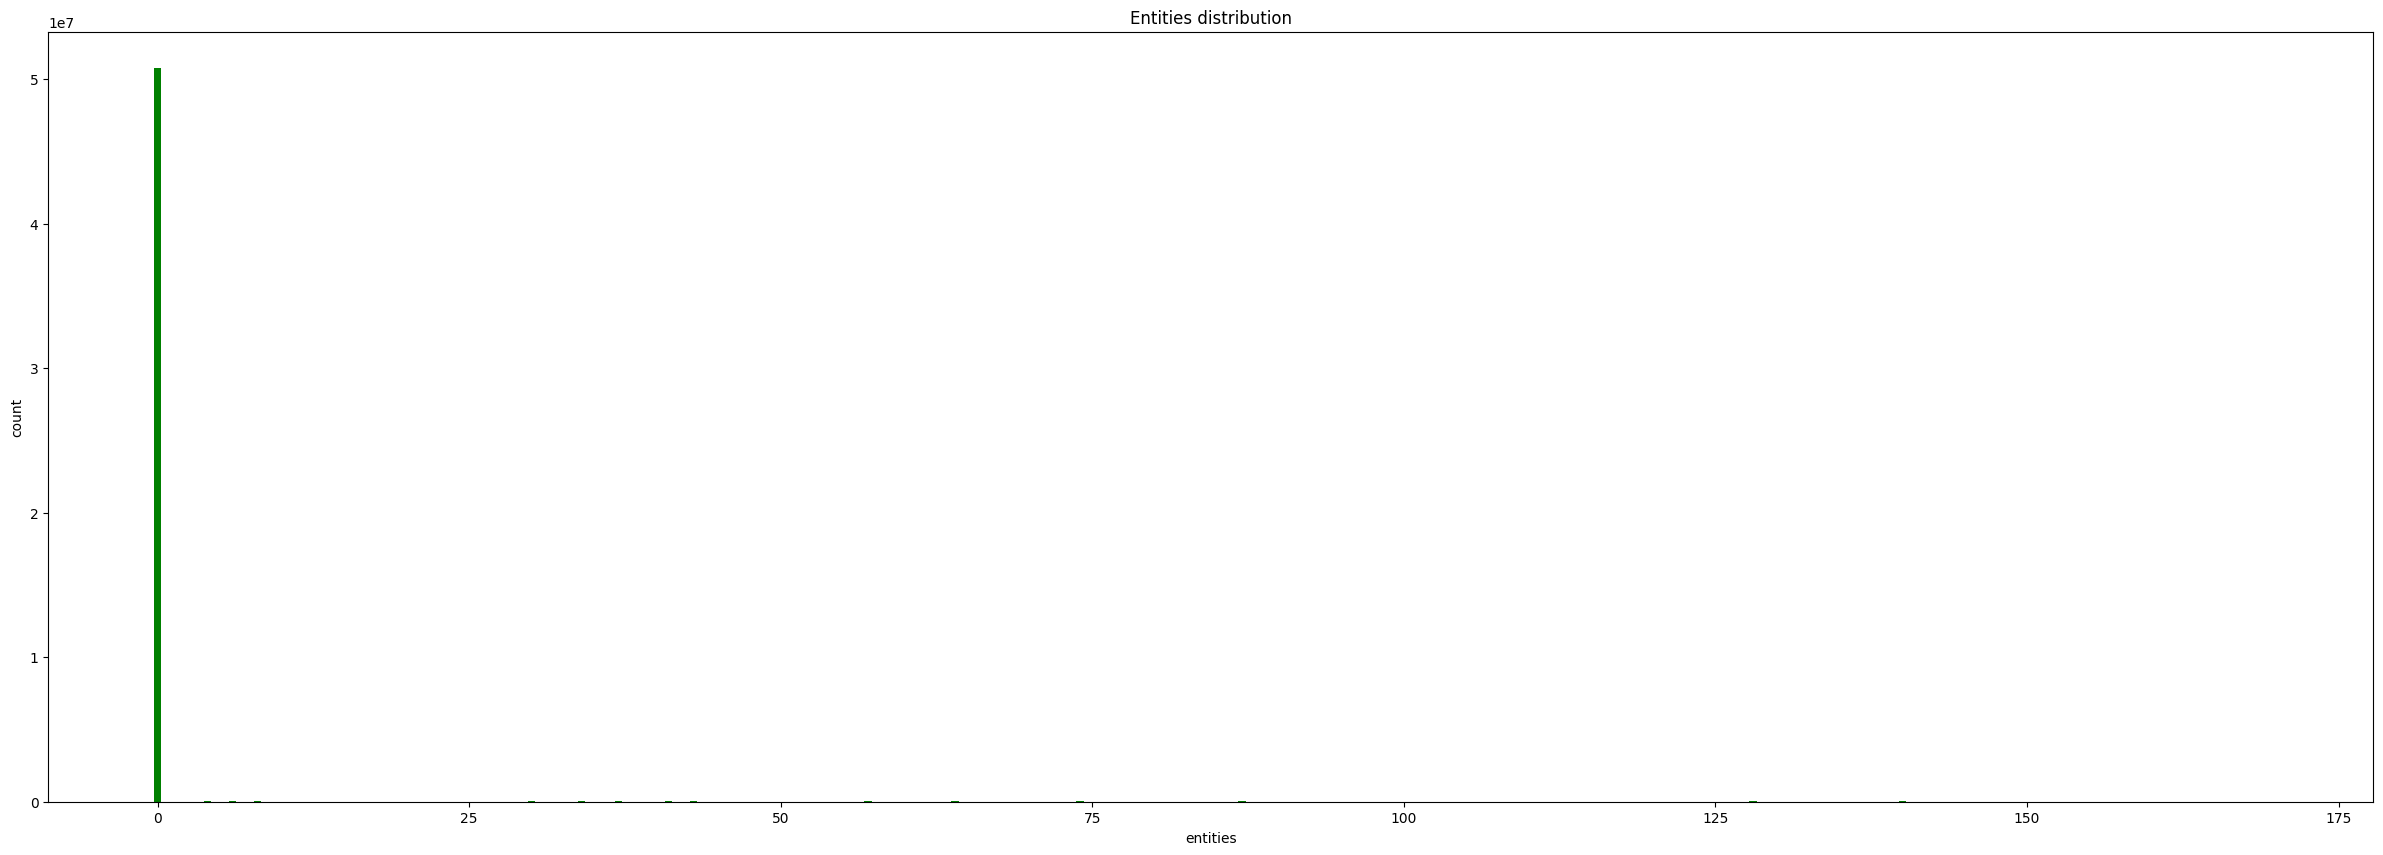

In [79]:
fig = plt.figure(figsize = (30, 10))
plt.bar(dict_entities.keys(), dict_entities.values(), color ='green', width = 0.6)
plt.xlabel("entities")
plt.ylabel("count")
plt.title("Entities distribution")
plt.show()

## Mapping indexes to new tags

In [9]:
dict_mapping = {0:0, 41:1, 87:2, 34:3, 37:4}

In [10]:
# O means the word doesn’t correspond to any entity.
# B-XXX means the word corresponds to the beginning of a XXX entity.
entity2index  = { entities_names[value]: dict_mapping[value] for value in [0, 41, 87, 34, 37]} 
entity2index

{'O': 0,
 'B-DebtInstrumentInterestRateStatedPercentage': 1,
 'B-LineOfCreditFacilityMaximumBorrowingCapacity': 2,
 'B-DebtInstrumentBasisSpreadOnVariableRate1': 3,
 'B-DebtInstrumentFaceAmount': 4}

In [11]:
index2entity = { dict_mapping[value]: entities_names[value]  for value in [0, 41, 87, 34, 37]} 
index2entity

{0: 'O',
 1: 'B-DebtInstrumentInterestRateStatedPercentage',
 2: 'B-LineOfCreditFacilityMaximumBorrowingCapacity',
 3: 'B-DebtInstrumentBasisSpreadOnVariableRate1',
 4: 'B-DebtInstrumentFaceAmount'}

## Create new dataset with 4 most repeated entities

In [12]:
def create_dataset(row):
    new_row_ner_tags = []
    for tag in row['ner_tags']:
        if tag in [0, 41, 87, 34, 37]:
            new_row_ner_tags.append(dict_mapping[tag])
        else:
            # set by O which means the word doesn’t correspond to any entity.
            new_row_ner_tags.append(0)
    row['ner_tags'] = new_row_ner_tags
    return row

In [13]:
new_finer = finer.map(create_dataset)
new_finer

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 900384
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 112494
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 108378
    })
})

In [14]:
new_finer_dataset = new_finer.filter(lambda row: 1 in row['ner_tags'] or
                                                  2 in row['ner_tags'] or
                                                  3 in row['ner_tags'] or
                                                  4 in row['ner_tags'] )
new_finer_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 28363
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3741
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3053
    })
})

In [15]:
print(new_finer_dataset['train'][0]['ner_tags'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Tokenize dataset

In [16]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [17]:
def padding_ner_tags(ner_tags, word_ids, fill_complete_word=True):
  new_ner_tags = []
  previous_word_id = None
  for word_id in word_ids:
    if word_id is None:
      # Special tokens ([CLS], [SEP]) have a word_id that is None, 
      # they are set to -100 to be ignored in the loss function.
      new_ner_tags.append(-100)
    elif word_id != previous_word_id:
      new_ner_tags.append(ner_tags[word_id])
    else:
      # if fill_complete_word=True, pad with ner_tags[word_id] value the complete word
      new_ner_tags.append(ner_tags[word_id] if fill_complete_word else -100)
    previous_word_id = word_id
  return new_ner_tags

In [18]:
def batch_tokenize(rows):
  rows_tokenized = tokenizer(rows['tokens'], truncation=True, is_split_into_words=True)
  rows_ner_tags = rows['ner_tags']
  new_labels = []
  for i, ner_tags in enumerate(rows_ner_tags):
    word_ids = rows_tokenized.word_ids(i)
    # Padding ner_tags to aling with the number of sentence-piece tokens 
    new_labels.append(padding_ner_tags(ner_tags, word_ids, fill_complete_word=True))
  rows_tokenized['labels'] = new_labels
  return rows_tokenized

In [19]:
# Tokenize and padding ner_tags, additionally remove 'id', 'tokens', 'ner_tags'
tokenized_datasets = new_finer_dataset.map(batch_tokenize, batched=True, remove_columns=new_finer_dataset['train'].column_names)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 28363
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3741
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3053
    })
})

## Finetunning distilbert-base-cased with new dataset

In [20]:
model = AutoModelForTokenClassification.from_pretrained( "distilbert-base-cased", id2label=index2entity, label2id=entity2index)
model

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

In [21]:
model.config.num_labels

5

#### Load sequence metric evaluator

In [22]:
metric = evaluate.load('seqeval')

#### Set hyperparameters

In [23]:
finetunned_ner_classifier_distil_bert = './../../models/ner-classifier-distil-bert'

args = TrainingArguments(finetunned_ner_classifier_distil_bert,
                         evaluation_strategy = "epoch",
                         save_strategy="epoch",
                         learning_rate = 2e-5,
                         num_train_epochs=5,
                         weight_decay=0.01,
                         logging_steps=50, # default 500,
                        )

#### Define data collator

In [24]:
# Data collator that will dynamically pad the inputs received, as well as the labels. 
# The id to use when padding the labels (-100 will be automatically ignore by PyTorch loss functions)
# input_ids with 0 
# attention_mask with 0
# labels with -100
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
data_collator

DataCollatorForTokenClassification(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, label_pad_token

#### Define a sample train and validation test (only for testing purposes)

In [25]:
train_dataset = tokenized_datasets['train'].select(range(100))
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})

In [26]:
eval_dataset = tokenized_datasets['validation'].select(range(10))
eval_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 10
})

In [27]:
def batch_compute_metrics(eval_preds):
  list_logits, list_labels = eval_preds
  predictions = np.argmax(list_logits, axis=2)
  true_labels = [[index2entity[l] for l in label if l!=-100] for label in list_labels]
  true_predictions = [[index2entity[p] for p,l in zip(prediction, label) if l!=-100] for prediction, label in zip(predictions, list_labels)]
  all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
  print(f'all_metrics: {all_metrics}')
  return {"precision": all_metrics['overall_precision'],
          "recall": all_metrics['overall_recall'],
          "f1": all_metrics['overall_f1'],
          "accuracy": all_metrics['overall_accuracy']}

In [28]:
trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset,
                  data_collator=data_collator,
                  compute_metrics=batch_compute_metrics,
                  tokenizer=tokenizer)

In [29]:
trainer.train()

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/c325018/virtualenvs/NER-classifier-DistilBERT/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/c325018/virtualenvs/NER-classifier-DistilBERT/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


all_metrics: {'DebtInstrumentBasisSpreadOnVariableRate1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 6}, 'DebtInstrumentFaceAmount': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 4}, 'DebtInstrumentInterestRateStatedPercentage': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 3}, 'LineOfCreditFacilityMaximumBorrowingCapacity': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 18}, 'overall_precision': 0.0, 'overall_recall': 0.0, 'overall_f1': 0.0, 'overall_accuracy': 0.9560906515580736}
{'eval_loss': 0.21711313724517822, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_accuracy': 0.9560906515580736, 'eval_runtime': 0.2679, 'eval_samples_per_second': 37.331, 'eval_steps_per_second': 7.466, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/Users/c325018/virtualenvs/NER-classifier-DistilBERT/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


all_metrics: {'DebtInstrumentBasisSpreadOnVariableRate1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 6}, 'DebtInstrumentFaceAmount': {'precision': 0.13636363636363635, 'recall': 0.75, 'f1': 0.23076923076923075, 'number': 4}, 'DebtInstrumentInterestRateStatedPercentage': {'precision': 0.16666666666666666, 'recall': 0.3333333333333333, 'f1': 0.2222222222222222, 'number': 3}, 'LineOfCreditFacilityMaximumBorrowingCapacity': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 18}, 'overall_precision': 0.14285714285714285, 'overall_recall': 0.12903225806451613, 'overall_f1': 0.13559322033898305, 'overall_accuracy': 0.953257790368272}
{'eval_loss': 0.16013747453689575, 'eval_precision': 0.14285714285714285, 'eval_recall': 0.12903225806451613, 'eval_f1': 0.13559322033898305, 'eval_accuracy': 0.953257790368272, 'eval_runtime': 0.0695, 'eval_samples_per_second': 143.922, 'eval_steps_per_second': 28.784, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/Users/c325018/virtualenvs/NER-classifier-DistilBERT/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


all_metrics: {'DebtInstrumentBasisSpreadOnVariableRate1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 6}, 'DebtInstrumentFaceAmount': {'precision': 0.058823529411764705, 'recall': 0.25, 'f1': 0.09523809523809523, 'number': 4}, 'DebtInstrumentInterestRateStatedPercentage': {'precision': 0.15384615384615385, 'recall': 0.6666666666666666, 'f1': 0.25, 'number': 3}, 'LineOfCreditFacilityMaximumBorrowingCapacity': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 18}, 'overall_precision': 0.1, 'overall_recall': 0.0967741935483871, 'overall_f1': 0.09836065573770492, 'overall_accuracy': 0.9504249291784702}
{'eval_loss': 0.11377833783626556, 'eval_precision': 0.1, 'eval_recall': 0.0967741935483871, 'eval_f1': 0.09836065573770492, 'eval_accuracy': 0.9504249291784702, 'eval_runtime': 0.0685, 'eval_samples_per_second': 145.902, 'eval_steps_per_second': 29.18, 'epoch': 3.0}
{'loss': 0.3374, 'grad_norm': 0.6935169696807861, 'learning_rate': 4.615384615384616e-06, 'epoch': 3.85}


  0%|          | 0/2 [00:00<?, ?it/s]

/Users/c325018/virtualenvs/NER-classifier-DistilBERT/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


all_metrics: {'DebtInstrumentBasisSpreadOnVariableRate1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 6}, 'DebtInstrumentFaceAmount': {'precision': 0.047619047619047616, 'recall': 0.25, 'f1': 0.08, 'number': 4}, 'DebtInstrumentInterestRateStatedPercentage': {'precision': 0.375, 'recall': 1.0, 'f1': 0.5454545454545454, 'number': 3}, 'LineOfCreditFacilityMaximumBorrowingCapacity': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 18}, 'overall_precision': 0.13793103448275862, 'overall_recall': 0.12903225806451613, 'overall_f1': 0.13333333333333333, 'overall_accuracy': 0.953257790368272}
{'eval_loss': 0.1066850870847702, 'eval_precision': 0.13793103448275862, 'eval_recall': 0.12903225806451613, 'eval_f1': 0.13333333333333333, 'eval_accuracy': 0.953257790368272, 'eval_runtime': 0.0557, 'eval_samples_per_second': 179.459, 'eval_steps_per_second': 35.892, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/Users/c325018/virtualenvs/NER-classifier-DistilBERT/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


all_metrics: {'DebtInstrumentBasisSpreadOnVariableRate1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 6}, 'DebtInstrumentFaceAmount': {'precision': 0.045454545454545456, 'recall': 0.25, 'f1': 0.07692307692307693, 'number': 4}, 'DebtInstrumentInterestRateStatedPercentage': {'precision': 0.42857142857142855, 'recall': 1.0, 'f1': 0.6, 'number': 3}, 'LineOfCreditFacilityMaximumBorrowingCapacity': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 18}, 'overall_precision': 0.13793103448275862, 'overall_recall': 0.12903225806451613, 'overall_f1': 0.13333333333333333, 'overall_accuracy': 0.9546742209631728}
{'eval_loss': 0.10189185291528702, 'eval_precision': 0.13793103448275862, 'eval_recall': 0.12903225806451613, 'eval_f1': 0.13333333333333333, 'eval_accuracy': 0.9546742209631728, 'eval_runtime': 0.0626, 'eval_samples_per_second': 159.765, 'eval_steps_per_second': 31.953, 'epoch': 5.0}
{'train_runtime': 19.982, 'train_samples_per_second': 25.022, 'train_steps_per_second': 3.2

TrainOutput(global_step=65, training_loss=0.28374807834625243, metrics={'train_runtime': 19.982, 'train_samples_per_second': 25.022, 'train_steps_per_second': 3.253, 'train_loss': 0.28374807834625243, 'epoch': 5.0})

#### Evaluation on validation set

In [30]:
trainer.evaluate()

  0%|          | 0/2 [00:00<?, ?it/s]

all_metrics: {'DebtInstrumentBasisSpreadOnVariableRate1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 6}, 'DebtInstrumentFaceAmount': {'precision': 0.045454545454545456, 'recall': 0.25, 'f1': 0.07692307692307693, 'number': 4}, 'DebtInstrumentInterestRateStatedPercentage': {'precision': 0.42857142857142855, 'recall': 1.0, 'f1': 0.6, 'number': 3}, 'LineOfCreditFacilityMaximumBorrowingCapacity': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 18}, 'overall_precision': 0.13793103448275862, 'overall_recall': 0.12903225806451613, 'overall_f1': 0.13333333333333333, 'overall_accuracy': 0.9546742209631728}


/Users/c325018/virtualenvs/NER-classifier-DistilBERT/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.10189185291528702,
 'eval_precision': 0.13793103448275862,
 'eval_recall': 0.12903225806451613,
 'eval_f1': 0.13333333333333333,
 'eval_accuracy': 0.9546742209631728,
 'eval_runtime': 0.0661,
 'eval_samples_per_second': 151.24,
 'eval_steps_per_second': 30.248,
 'epoch': 5.0}

## Save model and push to HuggingFace

In [31]:
trainer.save_model(finetunned_ner_classifier_distil_bert)

In [32]:
#trainer.push_to_hub(commit_message="Training first version")

## Model evaluation on test set

In [33]:
hf_finetunned_model = AutoModelForTokenClassification.from_pretrained(finetunned_ner_classifier_distil_bert, num_labels=len(index2entity))
#saved_model = AutoModelForTokenClassification.from_pretrained("florenciopaucar/ner-classifier-distil-bert")
hf_finetunned_model

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

#### Select a test sample (only for testing purposes)

In [34]:
test_dataset = tokenized_datasets['test'].select(range(10))
#test_dataset = tokenized_datasets['test']

#### Predict entities using tokenized test set

In [35]:
def predict_tokenized_sample(row):
    logits = hf_finetunned_model.forward(input_ids=torch.tensor(row['input_ids']).unsqueeze(0), 
                                attention_mask=torch.tensor(row['attention_mask']).unsqueeze(0))    
    value_preds = torch.argmax(logits.logits.squeeze(), axis=1)
    row['value_preds'] = value_preds
    return row

In [36]:
start_time_evaluation = time.time()
predicted_test_dataset = test_dataset.map(predict_tokenized_sample)
total_time_evaluation_pretrained = time.time() - start_time_evaluation
print(f'Total time prediction pretrained model: {total_time_evaluation_pretrained}')

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Total time prediction pretrained model: 0.50347900390625


#### Calculate model performance in test set

In [37]:
value_preds = predicted_test_dataset['value_preds']
labels = predicted_test_dataset['labels']

In [38]:
def evaluate_metrics_test_set(value_preds, labels):
  true_labels = [[index2entity[l] for l in label if l!=-100] for label in labels]
  true_predictions = [[index2entity[p] for p,l in zip(value_preds, label) if l!=-100] for value_preds, label in zip(value_preds, labels)]
  all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
  print(f'all_metrics: {all_metrics}')
  return {"precision": all_metrics['overall_precision'],
          "recall": all_metrics['overall_recall'],
          "f1": all_metrics['overall_f1'],
          "accuracy": all_metrics['overall_accuracy']}

In [39]:
metrics_test_set_pretrained_model = evaluate_metrics_test_set(value_preds, labels)
metrics_test_set_pretrained_model

all_metrics: {'DebtInstrumentBasisSpreadOnVariableRate1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 4}, 'DebtInstrumentFaceAmount': {'precision': 0.08695652173913043, 'recall': 0.2857142857142857, 'f1': 0.13333333333333333, 'number': 7}, 'DebtInstrumentInterestRateStatedPercentage': {'precision': 0.6666666666666666, 'recall': 1.0, 'f1': 0.8, 'number': 12}, 'LineOfCreditFacilityMaximumBorrowingCapacity': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 18}, 'overall_precision': 0.34146341463414637, 'overall_recall': 0.34146341463414637, 'overall_f1': 0.34146341463414637, 'overall_accuracy': 0.9084967320261438}


{'precision': 0.34146341463414637,
 'recall': 0.34146341463414637,
 'f1': 0.34146341463414637,
 'accuracy': 0.9084967320261438}

#### Confusion matrix

In [40]:
def create_confusion_matrix(value_preds, labels):
    # Initialize confusion matrix 
    # rows = prediction, columns = real labels
    cm = []
    for i in range(0,5):
        temp = []
        for j in range(0,5):
            temp.append(0)
        cm.append(temp)
    
    for pred, label in zip(value_preds, labels):
        # Delete [CLS] and [SEP] tags which are the first and last element
        pred = pred[1:-1]
        label = label[1:-1]
        for p,l in zip(pred, label):
            cm[p][l] +=1
    return cm

In [41]:
cm = create_confusion_matrix(value_preds, labels)
cm_df = pd.DataFrame(cm, columns=["0", "1", "2", "3", "4"])
print(f'rows: predicted values ')
print(f'columns: real label values ')
display(HTML(cm_df.to_html()))

rows: predicted values 
columns: real label values 


,0,1,2,3,4
0,403,0,7,3,5
1,6,12,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,9,0,11,1,2


## Export to ONNX

In [42]:
save_onnx_model_directory = "./../../models/onnx/"
os.mkdir(save_onnx_model_directory)

#### Select a sample input

In [43]:
sample_input_ids = test_dataset[0]['input_ids']
sample_attention_mask = test_dataset[0]['attention_mask']

In [44]:
# Padding to match ONNX input
sample_input_ids_padded = F.pad(input=torch.tensor(sample_input_ids), pad=(0, 512 - len(sample_input_ids)), mode='constant', value=0)
sample_attention_mask_padded = F.pad(input=torch.tensor(sample_attention_mask), pad=(0, 512 - len(sample_attention_mask)), mode='constant', value=0)

#### Export the model to ONNX

In [45]:
torch.onnx.export(hf_finetunned_model,                                         # model being run
                (sample_input_ids_padded, sample_attention_mask_padded),       # model input (or a tuple for multiple inputs)
                save_onnx_model_directory + 'model.onnx',                      # where to save the model (can be a file or file-like object)
                export_params=True,                                            # store the trained parameter weights inside the model file
                opset_version=10,                                              # the ONNX version to export the model to
                do_constant_folding=True,                                      # whether to execute constant folding for optimization
                input_names = ['input_ids', 'attention_mask'],                 # the model's input names
                output_names = ['logits'],                                     # the model's output names
                dynamic_axes={'input' : {0 : 'batch_size'},                    # variable length axes
                              'output' : {0 : 'batch_size'}})

/Users/c325018/virtualenvs/NER-classifier-DistilBERT/lib/python3.10/site-packages/torch/onnx/utils.py:2095: UserWarning: Provided key input for dynamic axes is not a valid input/output name
  warnings.warn(
/Users/c325018/virtualenvs/NER-classifier-DistilBERT/lib/python3.10/site-packages/torch/onnx/utils.py:2095: UserWarning: Provided key output for dynamic axes is not a valid input/output name
  warnings.warn(
/Users/c325018/virtualenvs/NER-classifier-DistilBERT/lib/python3.10/site-packages/transformers/models/distilbert/modeling_distilbert.py:246: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


In [46]:
#onnx_model = onnx.load(save_onnx_model_directory + 'model.onnx')
#onnx.checker.check_model(onnx_model)

#### Sanity check compare hf finetunned and onnx for sample input

In [47]:
ort_sess = ort.InferenceSession(save_onnx_model_directory + '/model.onnx')

In [48]:
onnx_output = ort_sess.run(None, {'input_ids': sample_input_ids_padded.numpy(),
                            'attention_mask':  sample_attention_mask_padded.numpy()})
onnx_output_logits = onnx_output[0][0][0:len(sample_input_ids)]

In [49]:
# HF finnetunned model results for sample
hf_output = hf_finetunned_model.forward(input_ids=torch.tensor(sample_input_ids).unsqueeze(0), 
                            attention_mask=torch.tensor(sample_attention_mask).unsqueeze(0)) 
hf_output_logits = np.asarray(hf_output.logits[0].detach().numpy())

In [50]:
bool(onnx_output_logits.all() == hf_output_logits.all())


True

## Comparison HF pretrained and ONNX model metrics

In [51]:
def onnx_predict_tokenized_sample(row):
    # Pad input_ids and attention_mask to 512 for onnx model input dimensions
    sample_input_ids_padded = F.pad(input=torch.tensor(row['input_ids']), pad=(0, 512 - len(row['input_ids'])), mode='constant', value=0)
    sample_attention_mask_padded = F.pad(input=torch.tensor(row['attention_mask']), pad=(0, 512 - len(row['attention_mask'])), mode='constant', value=0)
    # Obtain ouput from the onnx model
    onnx_output = ort_sess.run(None, {'input_ids': sample_input_ids_padded.numpy(),
                            'attention_mask':  sample_attention_mask_padded.numpy()})
    # Slice the ouputs as input dimension, do not consider prediction probs for the padding
    onnx_output_logits = torch.tensor(onnx_output[0].squeeze()[0:len(row['input_ids'])])
    # Argmax logits predictions
    value_preds = torch.argmax(onnx_output_logits, axis=1)
    row['value_preds'] = value_preds
    return row

In [52]:
start_time_evaluation_onnx = time.time()
onnx_predicted_test_dataset = test_dataset.map(onnx_predict_tokenized_sample)
total_time_evaluation_onnx = time.time() - start_time_evaluation_onnx

Parameter 'function'=<function onnx_predict_tokenized_sample at 0x3783e25f0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [53]:
onnx_value_preds = onnx_predicted_test_dataset['value_preds']
onnx_labels = onnx_predicted_test_dataset['labels']

In [54]:
metrics_test_set_onnx_model = evaluate_metrics_test_set(value_preds, labels)
metrics_test_set_onnx_model


all_metrics: {'DebtInstrumentBasisSpreadOnVariableRate1': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 4}, 'DebtInstrumentFaceAmount': {'precision': 0.08695652173913043, 'recall': 0.2857142857142857, 'f1': 0.13333333333333333, 'number': 7}, 'DebtInstrumentInterestRateStatedPercentage': {'precision': 0.6666666666666666, 'recall': 1.0, 'f1': 0.8, 'number': 12}, 'LineOfCreditFacilityMaximumBorrowingCapacity': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 18}, 'overall_precision': 0.34146341463414637, 'overall_recall': 0.34146341463414637, 'overall_f1': 0.34146341463414637, 'overall_accuracy': 0.9084967320261438}


{'precision': 0.34146341463414637,
 'recall': 0.34146341463414637,
 'f1': 0.34146341463414637,
 'accuracy': 0.9084967320261438}

In [55]:
metrics_test_set_pretrained_model == metrics_test_set_onnx_model

True

## Comparison HF pretrained and ONNX model prediction time


In [56]:
total_time_evaluation_onnx


1.076963186264038

In [57]:
total_time_evaluation_pretrained

0.50347900390625

In [58]:
print(f'Model ONNX is {total_time_evaluation_pretrained - total_time_evaluation_onnx } seconds fast than HF pretrained mode')

Model ONNX is -0.5734841823577881 seconds fast than HF pretrained mode
